<a href="https://colab.research.google.com/github/theabdulbasitt/transformer-model-from-scratch/blob/main/Assig_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Designing the Transformer-Based LLM**

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import math

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        # Create a long enough 'pe' matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        # Compute the positional encodings once in log space.
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position.float() * div_term)
        pe[:, 1::2] = torch.cos(position.float() * div_term)
        pe = pe.unsqueeze(0)  # Shape: [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: [batch_size, seq_len, d_model]
        x = x + self.pe[:, :x.size(1), :]
        return x

# Multi-Head Attention Mechanism
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_k = d_model // num_heads  # Dimension of each head
        self.num_heads = num_heads

        # Linear layers for Q, K, V
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)

        # Output linear layer
        self.fc = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(0.1)
        self.scale = math.sqrt(self.d_k)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        # Linear projection and split into heads
        Q = self.w_q(query).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)  # [B, H, L, Dk]
        K = self.w_k(key).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.w_v(value).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        # Scaled Dot-Product Attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale  # [B, H, L, L]
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attn = torch.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        context = torch.matmul(attn, V)  # [B, H, L, Dk]

        # Concatenate heads
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)  # [B, L, D]

        # Final linear layer
        output = self.fc(context)
        return output

# Position-wise Feed-Forward Network
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(0.1)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        # Apply two linear transformations with ReLU activation in between
        return self.linear2(self.dropout(torch.relu(self.linear1(x))))

# Encoder Layer
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff=2048):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = PositionwiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)
        self.dropout = nn.Dropout(0.1)

    def forward(self, src, src_mask=None):
        # Self-attention with residual connection and layer normalization
        src2 = self.norm1(src)
        attn_output = self.self_attn(src2, src2, src2, src_mask)
        src = src + self.dropout(attn_output)

        # Feed-forward network with residual connection and layer normalization
        src2 = self.norm2(src)
        ffn_output = self.ffn(src2)
        src = src + self.dropout(ffn_output)
        return src

# Decoder Layer
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff=2048):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = PositionwiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)
        self.norm3 = nn.LayerNorm(d_model, eps=1e-6)
        self.dropout = nn.Dropout(0.1)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None):
        # Masked self-attention with residual connection and layer normalization
        tgt2 = self.norm1(tgt)
        attn_output = self.self_attn(tgt2, tgt2, tgt2, tgt_mask)
        tgt = tgt + self.dropout(attn_output)

        # Encoder-decoder attention with residual connection and layer normalization
        tgt2 = self.norm2(tgt)
        attn_output = self.enc_dec_attn(tgt2, memory, memory, memory_mask)
        tgt = tgt + self.dropout(attn_output)

        # Feed-forward network with residual connection and layer normalization
        tgt2 = self.norm3(tgt)
        ffn_output = self.ffn(tgt2)
        tgt = tgt + self.dropout(ffn_output)
        return tgt

# Encoder
class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff=2048, max_len=5000):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff)
            for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(0.1)

    def forward(self, src, src_mask=None):
        # Embed and add positional encoding
        src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoding(src)
        src = self.dropout(src)

        # Pass through encoder layers
        for layer in self.layers:
            src = layer(src, src_mask)
        return src

# Decoder
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff=2048, max_len=5000):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff)
            for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(0.1)
        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None):
        # Embed and add positional encoding
        tgt = self.embedding(tgt) * math.sqrt(self.d_model)
        tgt = self.pos_encoding(tgt)
        tgt = self.dropout(tgt)

        # Pass through decoder layers
        for layer in self.layers:
            tgt = layer(tgt, memory, tgt_mask, memory_mask)

        # Final linear layer to generate predictions
        output = self.fc_out(tgt)
        return output

# Full Transformer Model
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512,
                 num_layers=6, num_heads=8, d_ff=2048, max_len=5000):
        super(Transformer, self).__init__()
        self.encoder = Encoder(src_vocab_size, d_model, num_layers, num_heads, d_ff, max_len)
        self.decoder = Decoder(tgt_vocab_size, d_model, num_layers, num_heads, d_ff, max_len)

    def make_src_mask(self, src):
        # Create a mask for padding tokens in the source sequences
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)  # Shape: [B, 1, 1, L_src]
        return src_mask

    def make_tgt_mask(self, tgt):
        # Create a mask for padding tokens and future tokens in the target sequences
        tgt_pad_mask = (tgt != 0).unsqueeze(1).unsqueeze(2)  # Shape: [B, 1, 1, L_tgt]
        tgt_len = tgt.size(1)
        tgt_sub_mask = torch.tril(torch.ones((tgt_len, tgt_len), device=tgt.device)).bool()  # Shape: [L_tgt, L_tgt]
        tgt_mask = tgt_pad_mask & tgt_sub_mask  # Combine masks
        return tgt_mask

    def forward(self, src, tgt):
        src_mask = self.make_src_mask(src)
        tgt_mask = self.make_tgt_mask(tgt)

        memory = self.encoder(src, src_mask)
        output = self.decoder(tgt, memory, tgt_mask, src_mask)
        return output


# **Data Loading and Preprocessing**

In [ ]:
import pandas as pd
import re
import spacy
from collections import Counter

# Load the dataset
df = pd.read_csv('/content/samsum-test.csv')
df = df[['dialogue', 'summary']]

# Clean text
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

df['dialogue'] = df['dialogue'].apply(clean_text)
df['summary'] = df['summary'].apply(clean_text)

# Tokenization
nlp = spacy.load('en_core_web_sm')

def tokenize(text):
    return [token.text.lower() for token in nlp.tokenizer(text)]

# Vocabulary class
class Vocabulary:
    def __init__(self, freq_threshold):
        self.freq_threshold = freq_threshold
        self.itos = {0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>'}
        self.stoi = {v: k for k, v in self.itos.items()}

    def __len__(self):
        return len(self.itos)

    def build_vocabulary(self, sentences):
        frequencies = Counter()
        idx = 4  # Starting index for new tokens

        for sentence in sentences:
            tokens = tokenize(sentence)
            frequencies.update(tokens)

        # Add tokens to vocabulary if they meet the frequency threshold
        for word, freq in frequencies.items():
            if freq >= self.freq_threshold:
                self.stoi[word] = idx
                self.itos[idx] = word
                idx += 1

def numericalize(text, vocab):
    tokenized_text = tokenize(text)
    return [
        vocab.stoi.get(token, vocab.stoi['<UNK>'])
        for token in tokenized_text
    ]

# Build vocabularies
freq_threshold = 2
src_vocab = Vocabulary(freq_threshold)
tgt_vocab = Vocabulary(freq_threshold)

src_vocab.build_vocabulary(df['dialogue'].tolist())
tgt_vocab.build_vocabulary(df['summary'].tolist())

print(f"Source Vocabulary Size: {len(src_vocab)}")
print(f"Target Vocabulary Size: {len(tgt_vocab)}")


Source Vocabulary Size: 3798
Target Vocabulary Size: 1511


# **Dataset Preparation**

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Dataset class
class SamSumDataset(Dataset):
    def __init__(self, df, src_vocab, tgt_vocab, max_src_len=100, max_tgt_len=50):
        self.df = df
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        self.max_src_len = max_src_len
        self.max_tgt_len = max_tgt_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        src_text = self.df.iloc[idx]['dialogue']
        tgt_text = self.df.iloc[idx]['summary']

        # Numericalize
        src_seq = numericalize(src_text, self.src_vocab)
        tgt_seq = numericalize(tgt_text, self.tgt_vocab)

        # Add <SOS> and <EOS> tokens to target sequence
        tgt_seq = [self.tgt_vocab.stoi['<SOS>']] + tgt_seq + [self.tgt_vocab.stoi['<EOS>']]

        # Truncate sequences to max lengths
        src_seq = src_seq[:self.max_src_len]
        tgt_seq = tgt_seq[:self.max_tgt_len]

        return torch.tensor(src_seq), torch.tensor(tgt_seq)

# Collate function
def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)

    # Pad sequences
    src_batch = torch.nn.utils.rnn.pad_sequence(src_batch, padding_value=src_vocab.stoi['<PAD>'], batch_first=True)
    tgt_batch = torch.nn.utils.rnn.pad_sequence(tgt_batch, padding_value=tgt_vocab.stoi['<PAD>'], batch_first=True)

    return src_batch, tgt_batch

# Split the DataFrame into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

# Create training and validation datasets
train_dataset = SamSumDataset(train_df, src_vocab, tgt_vocab, max_src_len=100, max_tgt_len=50)
val_dataset = SamSumDataset(val_df, src_vocab, tgt_vocab, max_src_len=100, max_tgt_len=50)

# Create DataLoaders
batch_size = 32  # Adjust based on your computational resources
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


Training samples: 737
Validation samples: 82


# **Training the Model**

Epoch [1/3] completed in 334.01s
Average Training Loss: 60.2694, Validation Loss: 54.4367
Model saved.
Epoch [2/3] completed in 330.25s
Average Training Loss: 59.9649, Validation Loss: 54.4366
Model saved.
Epoch [3/3] completed in 330.66s
Average Training Loss: 59.8423, Validation Loss: 54.4363
Model saved.
Training completed.


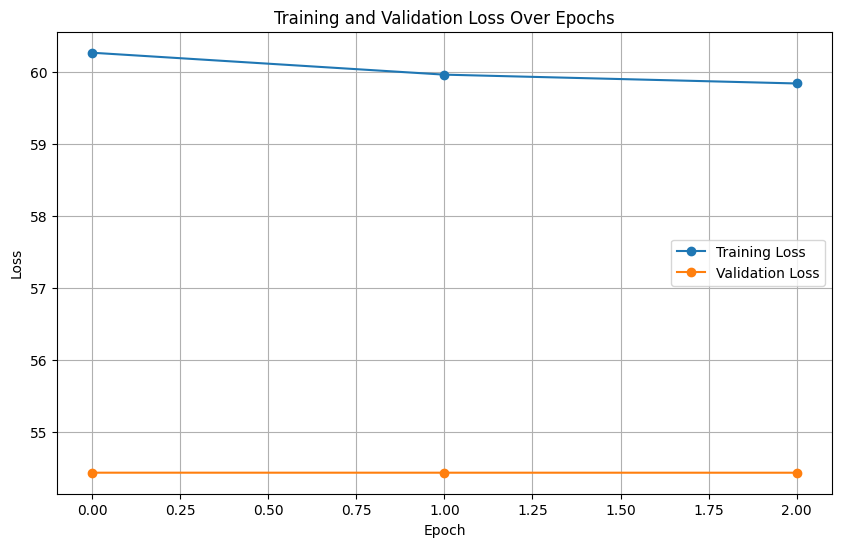

In [ ]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import time

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model
src_vocab_size = len(src_vocab)
tgt_vocab_size = len(tgt_vocab)
model = Transformer(
    src_vocab_size=src_vocab_size,
    tgt_vocab_size=tgt_vocab_size,
    d_model=512,
    num_layers=6,
    num_heads=8,
    d_ff=2048,
    max_len=5000
).to(device)

# Initialize optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.98), eps=1e-9)

# Custom learning rate scheduler with warm-up
class CustomSchedule(optim.lr_scheduler.LambdaLR):
    def __init__(self, optimizer, d_model, warmup_steps=4000, last_epoch=-1):
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        super(CustomSchedule, self).__init__(optimizer, self.lr_lambda, last_epoch=last_epoch)

    def lr_lambda(self, step):
        step = max(step, 1)
        return (self.d_model ** -0.5) * min(step ** -0.5, step * (self.warmup_steps ** -1.5))

scheduler = CustomSchedule(optimizer, d_model=512, warmup_steps=4000)

# Initialize loss function
criterion = nn.CrossEntropyLoss(ignore_index=src_vocab.stoi['<PAD>'])

# Initialize EarlyStopping
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        """
        Args:
            patience (int): How many epochs to wait after last time validation loss improved.
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            return False

        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False

        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
            return self.early_stop

early_stopping = EarlyStopping(patience=3, min_delta=0.001)

# Initialize TensorBoard writer
writer = SummaryWriter('runs/transformer_experiment')

# Training loop
num_epochs = 3
best_val_loss = float('inf')
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    total_loss = 0

    for batch_idx, (src_batch, tgt_batch) in enumerate(train_loader):
        src_batch = src_batch.to(device)
        tgt_batch = tgt_batch.to(device)

        # Prepare target sequences
        tgt_input = tgt_batch[:, :-1]
        tgt_output = tgt_batch[:, 1:].contiguous().view(-1)

        # Forward pass
        optimizer.zero_grad()
        output = model(src_batch, tgt_input)
        output = output.view(-1, output.size(-1))

        # Compute loss
        loss = criterion(output, tgt_output)

        # Backpropagation
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update parameters
        optimizer.step()

        # Update learning rate
        scheduler.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    elapsed_time = time.time() - start_time

    # Validation
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for src_batch, tgt_batch in val_loader:
            src_batch = src_batch.to(device)
            tgt_batch = tgt_batch.to(device)

            tgt_input = tgt_batch[:, :-1]
            tgt_output = tgt_batch[:, 1:].contiguous().view(-1)

            output = model(src_batch, tgt_input)
            output = output.view(-1, output.size(-1))

            loss = criterion(output, tgt_output)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Log losses to TensorBoard
    writer.add_scalar('Loss/train', avg_train_loss, epoch)
    writer.add_scalar('Loss/validation', avg_val_loss, epoch)

    print(f'Epoch [{epoch+1}/{num_epochs}] completed in {elapsed_time:.2f}s')
    print(f'Average Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    # Early Stopping Check
    if early_stopping(avg_val_loss):
        print("Early stopping triggered. Stopping training.")
        break

    # Save the model if validation loss has decreased
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_transformer_model.pth')
        print("Model saved.")

# Close TensorBoard writer
writer.close()

print("Training completed.")

# Plotting the training and validation loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# **Evaluation Metrics**

In [ ]:
from rouge_score import rouge_scorer, scoring
from tqdm import tqdm
import torch.nn.functional as F

# Load the best model
model.load_state_dict(torch.load('best_transformer_model.pth'))
model.to(device)
model.eval()

# Inference function
def generate_summary(model, src_sentence, src_vocab, tgt_vocab, max_len=50):
    model.eval()
    src_seq = numericalize(src_sentence, src_vocab)
    src_seq = torch.tensor(src_seq).unsqueeze(0).to(device)
    src_mask = model.make_src_mask(src_seq)

    # Encode the source sequence
    memory = model.encoder(src_seq, src_mask)

    # Initialize the decoder input with <SOS>
    ys = torch.ones(1, 1).fill_(tgt_vocab.stoi['<SOS>']).type(torch.long).to(device)

    for _ in range(max_len):
        tgt_mask = model.make_tgt_mask(ys)
        out = model.decoder(ys, memory, tgt_mask, src_mask)
        out = out[:, -1, :]  # Get the last time step
        prob = F.softmax(out, dim=-1)
        next_word = torch.argmax(prob, dim=1).item()
        ys = torch.cat([ys, torch.ones(1, 1).type_as(src_seq).fill_(next_word)], dim=1)
        if next_word == tgt_vocab.stoi['<EOS>']:
            break

    # Convert indices to words
    predicted_tokens = [tgt_vocab.itos[idx] for idx in ys.squeeze().tolist()]
    # Remove <SOS> and tokens after <EOS>
    if '<EOS>' in predicted_tokens:
        eos_index = predicted_tokens.index('<EOS>')
        predicted_tokens = predicted_tokens[1:eos_index]
    else:
        predicted_tokens = predicted_tokens[1:]
    return ' '.join(predicted_tokens)

# Generate summaries and collect references
references = []
hypotheses = []

for idx in tqdm(range(len(val_df))):
    src_text = val_df.iloc[idx]['dialogue']
    tgt_text = val_df.iloc[idx]['summary']

    # Generate summary
    generated_summary = generate_summary(model, src_text, src_vocab, tgt_vocab)

    # Append to lists
    references.append(tgt_text)
    hypotheses.append(generated_summary)

# Calculate ROUGE scores
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
aggregator = scoring.BootstrapAggregator()

for ref, hyp in zip(references, hypotheses):
    scores = scorer.score(ref, hyp)
    aggregator.add_scores(scores)

result = aggregator.aggregate()

# Print ROUGE scores
print("\nCustom Model ROUGE Scores:")
print("ROUGE-1:")
print(f"  Precision: {result['rouge1'].mid.precision:.4f}")
print(f"  Recall:    {result['rouge1'].mid.recall:.4f}")
print(f"  F1 Score:  {result['rouge1'].mid.fmeasure:.4f}")

print("ROUGE-2:")
print(f"  Precision: {result['rouge2'].mid.precision:.4f}")
print(f"  Recall:    {result['rouge2'].mid.recall:.4f}")
print(f"  F1 Score:  {result['rouge2'].mid.fmeasure:.4f}")

print("ROUGE-L:")
print(f"  Precision: {result['rougeL'].mid.precision:.4f}")
print(f"  Recall:    {result['rougeL'].mid.recall:.4f}")
print(f"  F1 Score:  {result['rougeL'].mid.fmeasure:.4f}")


<ipython-input-12-60b9e53ecda6>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_transformer_model.pth'))
100%|██████████| 82/82 [22:0


Custom Model ROUGE Scores:
ROUGE-1:
  Precision: 0.0155
  Recall:    0.0379
  F1 Score:  0.0205
ROUGE-2:
  Precision: 0.0000
  Recall:    0.0000
  F1 Score:  0.0000
ROUGE-L:
  Precision: 0.0140
  Recall:    0.0345
  F1 Score:  0.0186


# **Sample Text and Summarization**

In [ ]:
# Select a sample index from the validation set
sample_index = 0  # Change this index to test different samples

# Extract the sample dialogue and reference summary
sample_dialogue = val_df.iloc[sample_index]['dialogue']
reference_summary = val_df.iloc[sample_index]['summary']

print("\nSample Input Dialogue:")
print(sample_dialogue)

print("\nReference Summary:")
print(reference_summary)

# Generate the predicted summary
generated_summary = generate_summary(model, sample_dialogue, src_vocab, tgt_vocab)

print("\nGenerated Summary:")
print(generated_summary)

# Compare and analyze the summaries
print("\nComparison:")
print("Reference Summary:")
print(reference_summary)

print("\nGenerated Summary:")
print(generated_summary)



Sample Input Dialogue:
Olafur: are we doing anything for New Year's Eve? Nathalie: I was thinking about something classy, like opera or sth like that Zoe: how much does it cost? Olafur: opera is not for me Nathalie: so what do you propose? Nathalie: it's 100$ Olafur: I was thinking about partying somewhere Nathalie: partying sounds fun, as long as it will be classy Zoe: <file_link> Zoe: Breakfast at Tiffany's party sounds classy Olafur: <file_link> Olafur: is it classy enough? Nathalie: :O Nathalie: this club is AMAZING Zoe: whoa Nathalie: we'll going to Soho then Olafur: we just need to hurry up and buy some tickets soon Zoe: sure

Reference Summary:
Nathalie, Olafur and Zoe are planning the New Year's Eve. Nathalie wants something classy. Olafur doesn't like opera. They want to go to the Breakfast at Tiffany's party in Soho.

Generated Summary:
left olivia year marcel leave think daniel marty phil supposed terry allergic book bottle delivery mom platform selling close graham special